In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.datasets import load_digits
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from scipy.stats import sem
from numpy import linalg as LA
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

## Calculating the margin

In [2]:
def compute_margin(X, y, w, b):
    margin = []
    for i in range(y.shape[0]):
        margin.append((y[i]*(np.dot(X[i,:], w)+b))/sqrt(sum(w**2))) 
    if min(margin) >= 0:
        return min(margin)
    return 0

## ELM-IMA with W_init = [0, ..., 0] 

In [3]:
import random
from sklearn.base import BaseEstimator, ClassifierMixin
class ELM_IMA(BaseEstimator, ClassifierMixin):

    # Inicialization of important parameters 
    def __init__(self, n_neurons, eta=0.1, lambda_param=0.01, delta_margin=10^-3,
                 IMA_iterations=10, max_updates=10000):
        self.n_neurons = n_neurons              # Neurons of hidden layer osf ELM
        self.eta = eta                          # Learning rate
        self.lambda_param = lambda_param        # Param important of soft margin
        self.delta_margin = delta_margin        # (1 + delta_margin) * fixed margin defines the minimum next margin of IMA
        self.IMA_iterations = IMA_iterations    # Maximum number of iterations of IMA
        self.max_updates = max_updates          # Maximum number of updates in one execution of FMP
        self.w = np.array([])                   # Vector of weights of the last layer of the ELM obtained after the training of the IMA
        self.w_elm = np.array([])               # Vector of weights of the last layer of the ELM obtained after the normal training of ELM
        self.H = np.array([])                   # H matrix of ELM (obtained with training data)
        self.Z = np.array([])                   # Z matrix of ELM
        self.b = 0

    # Fixed Margin Algorithm    
    def FMP_algorithm(self, X, y, w_init, b_init, fixed_margin, idx, s):
        t = 0
        iterations = 0
        w = w_init
        b = b_init
        norm_w = sqrt(sum(w**2))
        last_t = -1
        lambda_t = 0
        alpha = np.zeros((X.shape[0]))
        while True:
            last_t = t
            e=0
            for k in range(0, y.shape[0]):
                i = int(idx[k])
                if(y[i]*(np.dot(X[i,:], w)+b) <= fixed_margin * norm_w - self.lambda_param * alpha[i]):
                    if norm_w != 0:
                        lambda_t = 1 - (self.eta*fixed_margin)/norm_w
                    else:
                        lambda_t = 1
                    alpha = alpha * lambda_t
                    alpha[i] = alpha[i] + self.eta    
                    w = w * lambda_t + self.eta * y[i] * X[i,:]
                    norm_w = sqrt(sum(w**2))
                    b = b + self.eta*y[i]
                    t += 1
                    e += 1
                    if k > s:
                        s += 1
                        j = s
                    else:
                        j=e
                    idx[k], idx[j] = idx[j], idx[k]
            iterations += 1
            if (t > self.max_updates or last_t == t):
                break
        if t<= self.max_updates:
            convergence=1
        else:
            convergence=0
        return w, b, convergence, t, iterations, idx, s

    # IMA Algorithm
    def IM_algorithm(self, X, y):
        self.w = np.zeros(self.w_elm.shape[0])
        self.ws = [] 
        self.bs = [] 
        self.ws.append(self.w)
        self.bs.append(self.b)
        fixed_margin = 0#compute_margin(X, y, self.w_elm, self.b)
        t = 0
        convergence = 1
        updates=0
        iterations=0
        margin=[]
        margin.append(fixed_margin)
        idx = np.linspace(0, y.shape[0]-1, y.shape[0])
        s=0
        while convergence==1 and t<self.IMA_iterations:
            w, b, convergence, updates_, iterations_, idx, s = self.FMP_algorithm(X, y, self.w, self.b, fixed_margin, idx, s)
            if convergence == 1:
                self.w = w
                self.b = b
                self.ws.append(self.w)
                self.bs.append(self.b)
            updates += updates_
            iterations += iterations_
            norm_w = sqrt(sum(self.w**2))
            gamma1 = []
            gamma2 = []
            for i in range(0, y.shape[0]):
                if y[i] == 1:
                    gamma1.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
                else:
                    gamma2.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
            gamma1 = np.array(gamma1)
            gamma2 = np.array(gamma2)
            gamma1 = gamma1[gamma1>=0]
            gamma2 = gamma2[gamma2>=0]
            if len(gamma1) == 0:
                min_gamma1 = 0
            else:
                min_gamma1 = min(gamma1)
            if len(gamma2) == 0:
                min_gamma2 = 0
            else:
                min_gamma2 = min(gamma2)
            fixed_margin = max([(min_gamma1 + min_gamma2)/2, (1+self.delta_margin)*fixed_margin])
            margin.append(compute_margin(X, y, self.w, self.b))
            t += 1
        return t, updates, iterations, margin

    # Function that manage the training of IMA ELM
    def fit(self, X, y):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        X = X_new
        n = X.shape[1]
        self.Z = np.array([random.uniform(-1, 1) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        self.H = np.tanh(np.dot(X, self.Z))
        w = np.dot(np.linalg.pinv(self.H), y)  
        self.w_elm = w.reshape((w.shape[0],))
        iterations_IMA, updates, iterations, margin = self.IM_algorithm(self.H, y) 
        return iterations_IMA, updates, iterations, margin
            
    # Function to apply IMA ELM model
    def predict(self, X, use_IMA_w=True):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        H = np.tanh(np.dot(X_new, self.Z))
        if use_IMA_w == True:
            y_predicted = np.sign(np.dot(H, self.w) + self.b)
        else:
            y_predicted = np.sign(np.dot(H,  self.w_elm))
        y_predicted[y_predicted==0]=-1
        return y_predicted

## Function to get Results

In [4]:
def grid_l(X, y, p):
    # GridSearch for lambda and learning rate of IMA ELM
    parameters = {'lambda_param':np.linspace(0.01, 100, 50)}
    clf = ELM_IMA(n_neurons=p, delta_margin=10^-3, IMA_iterations=20, max_updates=10000)
    clf = GridSearchCV(clf, parameters, scoring='accuracy', cv=10, verbose=0)
    clf.fit(X, y)
    return clf.best_params_['lambda_param']
    

In [5]:
def results(X, y, n_splits, p, eta, IMA_iterations, lambda_param):      
    print(f'Parameters: p={p}, eta={eta}, lambda={lambda_param}')
    # Stratified k fold cross validation
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=72)
    i=0
    
    train_accuracy_IM_ELM = np.zeros(n_splits)
    test_accuracy_IM_ELM = np.zeros(n_splits)
    margin_IM_ELM = np.zeros(n_splits)
    updates = np.zeros(n_splits)
    iterations_FMP = np.zeros(n_splits) 
    iterations_IMA = np.zeros(n_splits)
    margins=[]
          
    for train_index, test_index in kf.split(X, y):
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]
               
        # ELM-IMA
        clf = ELM_IMA(n_neurons=p, eta=eta, lambda_param=lambda_param, delta_margin=10^-3, IMA_iterations=IMA_iterations, max_updates=10000)
        iterations_IMA[i], updates[i], iterations_FMP[i], margin = clf.fit(X_train, y_train)
        margins.append(margin)
        y_hat=clf.predict(X_test, use_IMA_w = True)
        y_hat_train=clf.predict(X_train, use_IMA_w = True)
        margin_IM_ELM[i] = compute_margin(clf.H[:,:], y_train, clf.w, clf.b)
        train_accuracy_IM_ELM[i] = accuracy_score(y_train, y_hat_train)   
        test_accuracy_IM_ELM[i] = accuracy_score(y_test, y_hat)
        Z = clf.Z
                
        i+=1
        
    print("********* Results ELM-IMA **************")
    print("Acc train: " + '{:.4f}'.format(train_accuracy_IM_ELM.mean())+ "+/-" + '{:.4f}'.format(train_accuracy_IM_ELM.std()))
    print("Acc test: " + '{:.4f}'.format(test_accuracy_IM_ELM.mean()) + "+/-" + '{:.4f}'.format(test_accuracy_IM_ELM.std()))
    print("Iterations: " + '{:.4f}'.format(iterations_FMP.mean())+ "+/-" + '{:.4f}'.format(iterations_FMP.std()))
    print("Iterations IMA: " + '{:.4f}'.format(iterations_IMA.mean())+ "+/-" + '{:.4f}'.format(iterations_IMA.std()))
    print("Updates: " + '{:.4f}'.format(updates.mean())+ "+/-" + '{:.4f}'.format(updates.std()))
    print("Margin: " + '{:.9f}'.format(margin_IM_ELM.mean())+ "+/-" + '{:.9f}'.format(margin_IM_ELM.std()))   
    return margins

In [6]:
def plot_margin_evolution(m):
    avg_margins = []
    sem_margins = []
    for i in range(len(m[0])):
        margins = []
        for j in range(len(m)):
            margins.append(m[j][i]) 
        avg_margins.append(np.mean(margins))
        sem_margins.append(sem(margins))
    x = np.array(range(len(avg_margins)))
    plt.figure(1)
    plt.plot(x, avg_margins)
    plt.grid()
    plt.figure(2)
    plt.errorbar(x, avg_margins, sem_margins, color = 'blue', marker='s', capsize=5)
    plt.grid()

In [7]:
def run(X,y, l):
    # Normalizing data:
    normalizer = MinMaxScaler()
    X = normalizer.fit_transform(X)
    n = len(X)
    if n>1000:
        n=1000
    for p in [n]:
        print(f"Experimento com {p} neurônios:" )
        m = results(X, y, n_splits=10, p=p, eta=0.1, IMA_iterations=20, lambda_param=l)
        plot_margin_evolution(m)
        print("\n\n")

Experimento com 150 neurônios:
Parameters: p=150, eta=0.1, lambda=0.01
********* Results ELM-IMA **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Iterations: 2955.8000+/-804.7235
Iterations IMA: 20.0000+/-0.0000
Updates: 8056.2000+/-2372.0470
Margin: 1.100301725+/-0.072379872





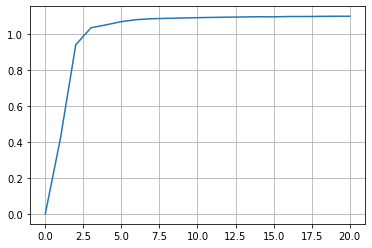

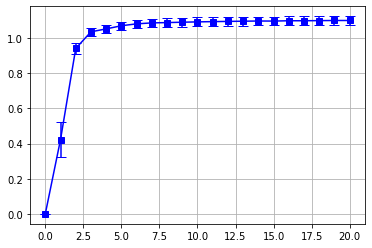

In [30]:
iris = datasets.load_iris()
X = iris.data
# setosa - 0, versicolor - 1, virginica - 2  
y = iris.target 
# O problema agora possui apenas as classes y=-1 e y=1
y[y>0] = 1
y[y==0] = -1
run(X, y, 0.01)


Experimento com 600 neurônios:
Parameters: p=600, eta=0.1, lambda=0.41775
********* Results ELM-IMA **************
Acc train: 1.0000+/-0.0000
Acc test: 0.9933+/-0.0111
Iterations: 350.2000+/-91.7429
Iterations IMA: 20.0000+/-0.0000
Updates: 3938.6000+/-1083.1211
Margin: 0.544243512+/-0.050718986





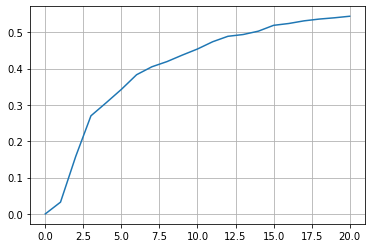

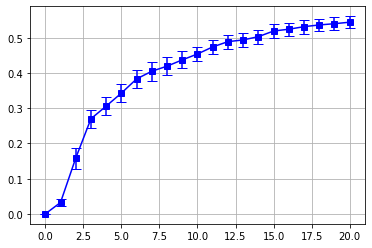

In [31]:
synthetic_dataset = pd.read_csv('data/synthetic_dataset/synthetic_control.data', sep="\s+",  header=None, engine='python')
X = synthetic_dataset.to_numpy()
y = np.concatenate((np.ones(100), np.ones(200)*-1, np.ones(100), np.ones(100)*-1,np.ones(100)))
run(X, y, 0.41775)

Experimento com 1000 neurônios:
Parameters: p=1000, eta=0.1, lambda=0.4498
********* Results ELM-IMA **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Iterations: 500.7000+/-121.9804
Iterations IMA: 20.0000+/-0.0000
Updates: 9538.6000+/-2614.8483
Margin: 2.125830219+/-0.057463379





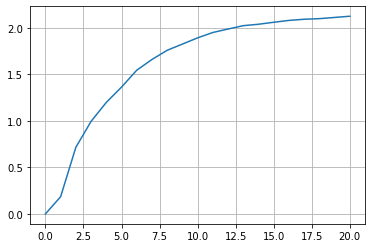

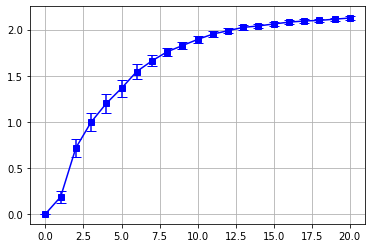

In [32]:
df = pd.read_csv('data/Mushroom/agaricus-lepiota.data', delimiter =',', header=None)
df = df.replace("?", np.nan) 
df = df.dropna() 
y = df[0].to_numpy()
X = df.drop([0], axis='columns')
X = pd.get_dummies(X).to_numpy()
y[np.where(y=='e')] = -1
y[np.where(y=='p')] = 1
y = np.array(y.tolist())
run(X, y, 0.4498)

Experimento com 1000 neurônios:
Parameters: p=1000, eta=0.1, lambda=0.7196856
********* Results ELM-IMA **************
Acc train: 1.0000+/-0.0000
Acc test: 1.0000+/-0.0000
Iterations: 429.1000+/-45.4653
Iterations IMA: 20.0000+/-0.0000
Updates: 6365.0000+/-907.2681
Margin: 0.111390523+/-0.010706204





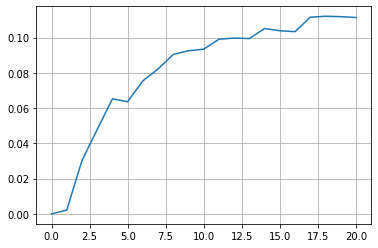

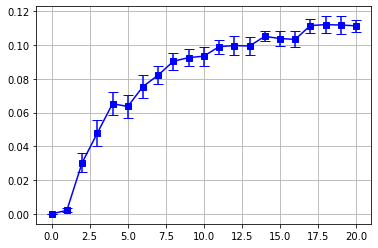

In [8]:
# read in banknote authentication set
banknotes = pd.read_csv('data/banknote/data_banknote_authentication.txt', names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
# convert to array
X = banknotes[['variance', 'skewness', 'curtosis', 'entropy']].to_numpy()
y = banknotes[['class']].to_numpy()
y[np.where(y==0)] = -1
run(X, y, 0.7196856)